/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipython-input-2683340041.py:49: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(5.0, 20.0), p=0.2),


number of classes: 5
class names: ['Basophil', 'Eosinophil', 'Lymphocyte', 'Monocyte', 'Neutrophil']
train dataset size: 750
val dataset size: 225
device: cuda
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


100%|██████████| 171M/171M [00:00<00:00, 241MB/s]


Epoch 0/49
----------
train Loss: 1.8894 Acc: 0.2853 FG Top-1: 0.2853
val Loss: 1.4889 Acc: 0.3867 FG Top-1: 0.3867

Epoch 1/49
----------
train Loss: 1.3734 Acc: 0.4053 FG Top-1: 0.4053
val Loss: 0.9108 Acc: 0.6133 FG Top-1: 0.6133

Epoch 2/49
----------
train Loss: 1.3152 Acc: 0.4267 FG Top-1: 0.4267
val Loss: 1.2079 Acc: 0.4756 FG Top-1: 0.4756

Epoch 3/49
----------
train Loss: 1.1035 Acc: 0.5480 FG Top-1: 0.5480
val Loss: 1.0245 Acc: 0.5289 FG Top-1: 0.5289

Epoch 4/49
----------
train Loss: 0.9658 Acc: 0.6053 FG Top-1: 0.6053
val Loss: 0.9141 Acc: 0.5822 FG Top-1: 0.5822

Epoch 5/49
----------
train Loss: 0.8691 Acc: 0.6787 FG Top-1: 0.6787
val Loss: 0.8709 Acc: 0.6978 FG Top-1: 0.6978

Epoch 6/49
----------
train Loss: 0.7907 Acc: 0.6973 FG Top-1: 0.6973
val Loss: 0.8016 Acc: 0.7156 FG Top-1: 0.7156

Epoch 7/49
----------
train Loss: 0.7596 Acc: 0.7213 FG Top-1: 0.7213
val Loss: 0.8393 Acc: 0.7511 FG Top-1: 0.7511

Epoch 8/49
----------
train Loss: 0.7218 Acc: 0.7427 FG Top-1: 0

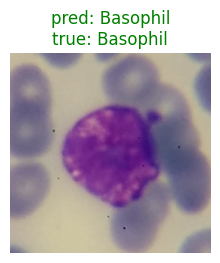

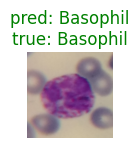

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image

import albumentations as A
import cv2
import random

cudnn.benchmark = True
plt.ioff()


class AlbumentationsCls:

    def __init__(self, p=0.5):
        self.p = p
        self.geom = A.Compose([
            A.RandomRotate90(p=0.5),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.ShiftScaleRotate(
                shift_limit=0.02,
                scale_limit=0.1,
                rotate_limit=10,
                border_mode=cv2.BORDER_REFLECT_101,
                p=0.5
            ),
        ])

        self.img_only = A.Compose([
            A.RandomBrightnessContrast(brightness_limit=0.15, contrast_limit=0.15, p=0.5),
            A.HueSaturationValue(hue_shift_limit=5, sat_shift_limit=10, val_shift_limit=10, p=0.3),
            A.GaussNoise(var_limit=(5.0, 20.0), p=0.2),
            A.GaussianBlur(blur_limit=3, p=0.2),
        ])

    def __call__(self, image: Image.Image):

        if random.random() > self.p:
            return image

        img = np.array(image)

        img = self.img_only(image=img)["image"]
        img = self.geom(image=img)["image"]

        return Image.fromarray(img)


def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)



data_transforms = {
    'train': transforms.Compose([
        AlbumentationsCls(p=0.5),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
}


def compute_fg_top1(outputs, labels):
    _, preds = torch.max(outputs, 1)
    correct = torch.sum(preds == labels.data)
    return correct

def train_model(model, criterion, optimizer, scheduler,
                dataloaders, dataset_sizes, num_epochs=20,
                best_model_path="best_cnn_resnet101.pth"):

    since = time.time()
    torch.save(model.state_dict(), best_model_path)
    best_acc = 0.0

    train_history = {'loss': [], 'acc': []}
    val_history = {'loss': [], 'acc': []}

    fg_train_history = []
    fg_val_history = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            running_fg_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)

                corrects = torch.sum(preds == labels.data)
                running_corrects += corrects

                fg_corrects = compute_fg_top1(outputs, labels)
                running_fg_corrects += fg_corrects

            if phase == 'train' and scheduler is not None:
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            epoch_fg_top1 = running_fg_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
                train_history['loss'].append(epoch_loss)
                train_history['acc'].append(epoch_acc.item())
                fg_train_history.append(epoch_fg_top1.item())
            else:
                val_history['loss'].append(epoch_loss)
                val_history['acc'].append(epoch_acc.item())
                fg_val_history.append(epoch_fg_top1.item())

            print(f'{phase} Loss: {epoch_loss:.4f} '
                  f'Acc: {epoch_acc:.4f} '
                  f'FG Top-1: {epoch_fg_top1:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), best_model_path)

        print()

    time_elapsed = time.time() - since
    print(f'Training completed in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    state_dict = torch.load(best_model_path, map_location=device)
    model.load_state_dict(state_dict)

    plt.figure()
    plt.plot(train_history['loss'], label='train loss')
    plt.plot(val_history['loss'], label='val loss')
    plt.title('Loss curve')
    plt.legend()
    plt.savefig('cnn_loss_curve.png')
    plt.close()

    plt.figure()
    plt.plot(train_history['acc'], label='train acc')
    plt.plot(val_history['acc'], label='val acc')
    plt.title('Top-1 Accuracy curve')
    plt.legend()
    plt.savefig('cnn_acc_curve.png')
    plt.close()

    plt.figure()
    plt.plot(fg_train_history, label='train FG Top-1')
    plt.plot(fg_val_history, label='val FG Top-1')
    plt.title('FG Top-1 Accuracy curve')
    plt.legend()
    plt.savefig('cnn_fg_top1_curve.png')
    plt.close()

    return model


def visualize_predictions(model, dataloaders, class_names, num_images=10):
    model.eval()
    inputs, classes = next(iter(dataloaders['val']))
    inputs = inputs.to(device)

    with torch.no_grad():
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

    plt.figure(figsize=(15, 10))
    for idx in range(min(num_images, inputs.size(0))):
        ax = plt.subplot(2, 5, idx + 1)
        ax.axis('off')
        ax.set_title(
            f'pred: {class_names[preds[idx]]}\ntrue: {class_names[classes[idx]]}',
            color='green' if preds[idx] == classes[idx] else 'red'
        )
        image = inputs.cpu().data[idx]
        imshow(image)
    plt.savefig('cnn_predictions.png')
    plt.close()


if __name__ == '__main__':

    data_dir = "/content/drive/MyDrive/Thesis/MaskRCNN/TestData_CNN"

    image_datasets = {
        x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
        for x in ['train', 'val']
    }

    batch_size = 2

    dataloaders = {
        x: torch.utils.data.DataLoader(
            image_datasets[x],
            batch_size=batch_size,
            shuffle=True if x == 'train' else False,
            num_workers=2,
            pin_memory=True
        ) for x in ['train', 'val']
    }

    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
    class_names = image_datasets['train'].classes
    num_classes = len(class_names)

    print(f"number of classes: {num_classes}")
    print(f"class names: {class_names}")
    print(f"train dataset size: {dataset_sizes['train']}")
    print(f"val dataset size: {dataset_sizes['val']}")


    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"device: {device}")

    model_ft = models.resnet101(weights='IMAGENET1K_V1')
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, num_classes)
    model_ft = model_ft.to(device)

    criterion = nn.CrossEntropyLoss()

    params = [p for p in model_ft.parameters() if p.requires_grad]
    optimizer_ft = optim.SGD(
        params,
        lr=0.003,
        momentum=0.9,
        weight_decay=1e-4
    )

    exp_lr_scheduler = lr_scheduler.StepLR(
        optimizer_ft,
        step_size=3,
        gamma=0.1
    )

    model_ft = train_model(
        model_ft, criterion, optimizer_ft, exp_lr_scheduler,
        dataloaders, dataset_sizes,
        num_epochs=50,
        best_model_path="cnn_resnet101_best.pth"
    )

    torch.save(model_ft.state_dict(), 'cnn_resnet101_final.pth')
    print("CNN model (ResNet101) has been saved.")

    visualize_predictions(model_ft, dataloaders, class_names)
